In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context("paper", font_scale=1.6)
sns.set_style('whitegrid')
from sklearn.metrics import roc_curve, auc


def progress(iteration, total, message=None):
    '''Simple progressbar
    '''
    if message is None:
        message = ''
    bars_string = int(float(iteration) / float(total) * 50.)
    print("\r|%-50s| %d%% (%s/%s) %s "% ('█'*bars_string+ "░" * \
                                     (50 - bars_string), float(iteration)/\
                                     float(total) * 100, iteration, total, \
                                     message), end='\r', flush=True)

    if iteration == total:
        print('\nCompleted!')

In [8]:
df = pd.read_csv('protein.spyogenes.txt.gz', sep='\t', header=None)
df.columns = ['GCA', 'Accession', 'eggNOG', 'E-value', 'Bitscore']
df = df.drop_duplicates(['GCA', 'eggNOG'])
df.head()

,GCA,Accession,eggNOG,E-value,Bitscore
0,GCA_900989965,WP_050137113.1,COG4983.faa.final_tree.fa,0.0,3182.2
1,GCA_900983035,WP_136288169.1,COG4983.faa.final_tree.fa,0.0,3178.0
2,GCA_900984465,WP_001222126.1,COG4983.faa.final_tree.fa,0.0,3171.7
3,GCA_001023495,WP_047716015.1,COG4983.faa.final_tree.fa,0.0,3159.2
4,GCA_900985025,WP_136293481.1,COG4983.faa.final_tree.fa,0.0,3150.4


In [12]:
df1 = pd.read_csv('41588_2019_417_MOESM3_ESM.csv', skiprows=2)
df1 = df1[~df1['Assembly accession number'].isna()]
df1 = df1.rename(columns={'Assembly accession number':'GCA'})
df1.head(2)

,Strain,Other Identifier,Country,Geographical Region,M Cluster,MLST,PopPUNK,Year,emm Family,emm Sub-type,...,Size (bp),N50 (bp),Insert size (average),Unnamed: 20,sample accession number,Reads,read length,Phred,AvgQual,Depth
0,NS2403,11826_4_60,Australia,Oceania,A-C5,ST335,98.0,2000,3,emm3.22,...,1767153.0,380038.0,245,NaN,ERS366814,1350000.0,100.0,33.0,36.5,73.0
1,NS2413,11826_4_61,Australia,Oceania,E6,ST109,63.0,2000,85,emm85.0,...,1784018.0,320921.0,225,NaN,ERS366815,1350000.0,100.0,33.0,36.6,73.0


In [13]:
df2 = pd.merge(df, \
         df1[['GCA', 'emm Family', 'emm Sub-type', 'tissue/source', 'Clinical', 'Invasive (pyseer)',]],\
        on='GCA')
df2.head()

,GCA,Accession,eggNOG,E-value,Bitscore,emm Family,emm Sub-type,tissue/source,Clinical,Invasive (pyseer)
0,GCA_900989965,WP_050137113.1,COG4983.faa.final_tree.fa,0.0,3182.2,9,emm9.0,"skin, soft tissue infection",Deep soft tissue infection,1
1,GCA_900989965,WP_136266006.1,COG0086.faa.final_tree.fa,0.0,1801.2,9,emm9.0,"skin, soft tissue infection",Deep soft tissue infection,1
2,GCA_900989965,WP_002993467.1,COG0085.faa.final_tree,0.0,1714.5,9,emm9.0,"skin, soft tissue infection",Deep soft tissue infection,1
3,GCA_900989965,WP_014407488.1,COG0458.faa.final_tree,0.0,1576.9,9,emm9.0,"skin, soft tissue infection",Deep soft tissue infection,1
4,GCA_900989965,WP_136265997.1,COG0178.faa.final_tree.fa,0.0,1447.5,9,emm9.0,"skin, soft tissue infection",Deep soft tissue infection,1


In [17]:
clinical = df2.Clinical.value_counts().index
clinical

Index(['Superficial soft tissue infection', 'iGAS',
       'Deep soft tissue infection', 'Pharyngitis', 'ND', 'Rheumatic fever',
       'Pneumonia', 'Scarlet fever', 'APSGN', 'Meningitis', 'Bacteremia',
       'Genital', 'Arthritis', 'Necrotising fasciitis', 'Fever',
       'SOB & asthma'],
      dtype='object')

In [18]:
def calculate_auc(clinical_name):
    test_df = df2.copy()
    test_df['Label'] = test_df['Clinical'].apply(lambda x: 1 if x == clinical_name else 0)
    
    all_eggNOGs = test_df['eggNOG'].value_counts().index
    
    auc_df = pd.DataFrame(columns=['Clinical', 'AUC'])
    
    for p, q in enumerate(all_eggNOGs):
        nn = test_df[test_df['eggNOG'] == q].copy()
        if len(nn.Label.value_counts()) == 2:
            nn.Label.value_counts().values[0]
            fpr, tpr, _ = roc_curve(nn.Label, nn.Bitscore)
            auc_df.loc[q, 'Clinical'] = clinical_name
            auc_df.loc[q, 'AUC'] = auc(fpr, tpr)
            auc_df.loc[q, 'Negative [0]'] = nn.Label.value_counts().values[0]
            auc_df.loc[q, 'Positive [1]'] = nn.Label.value_counts().values[1]
    return auc_df

In [19]:
from multiprocessing import Pool


pools = Pool(len(clinical))
results = []
for result in pools.imap(calculate_auc, clinical):
    results.append(result)
    progress(len(results), len(clinical))
pools.close()
pools.join()

|██████████████████████████████████████████████████| 100% (16/16)  
Completed!


In [20]:
auc_df_all = pd.concat(results)
auc_df_all['Negative [0]'] = auc_df_all['Negative [0]'].astype(int)
auc_df_all['Positive [1]'] = auc_df_all['Positive [1]'].astype(int)
auc_df_all.to_pickle('results/auc_df.pkl.gz')
auc_df_all.head()

,Clinical,AUC,Negative [0],Positive [1]
COG1788.faa.final_tree.fa,Superficial soft tissue infection,0.442777,953,386
COG1944.faa.final_tree.fa,Superficial soft tissue infection,0.50723,953,386
COG3599.faa.final_tree.fa,Superficial soft tissue infection,0.545176,953,386
COG2893.faa.final_tree.fa,Superficial soft tissue infection,0.504284,953,386
COG1799.faa.final_tree.fa,Superficial soft tissue infection,0.557117,953,386


In [40]:
auc_df_all.sort_values(['Positive [1]'], ascending=False).drop_duplicates('Clinical')

,Clinical,AUC,Negative [0],Positive [1]
COG1788.faa.final_tree.fa,Superficial soft tissue infection,0.442777,953,386
COG0452.faa.final_tree.fa,iGAS,0.478631,1088,251
COG0048.faa.final_tree.fa,Deep soft tissue infection,0.496941,1144,194
COG4758.faa.final_tree.fa,Pharyngitis,0.493256,1181,158
COG1187.faa.final_tree.fa,ND,0.47019,1234,105
COG0813.faa.final_tree.fa,Rheumatic fever,0.54239,1237,102
COG3634.faa.final_tree.fa,Pneumonia,0.450926,1296,40
COG1198.faa.final_tree.fa,Scarlet fever,0.717748,1310,28
COG0128.faa.final_tree.fa,APSGN,0.626663,1315,24
33T6Z.faa.final_tree.fa,Meningitis,0.382427,1317,16


In [21]:
auc_df_all = pd.read_pickle('results/auc_df.pkl.gz')
auc_df_all.head()

,Clinical,AUC,Negative [0],Positive [1]
COG1788.faa.final_tree.fa,Superficial soft tissue infection,0.442777,953,386
COG1944.faa.final_tree.fa,Superficial soft tissue infection,0.50723,953,386
COG3599.faa.final_tree.fa,Superficial soft tissue infection,0.545176,953,386
COG2893.faa.final_tree.fa,Superficial soft tissue infection,0.504284,953,386
COG1799.faa.final_tree.fa,Superficial soft tissue infection,0.557117,953,386


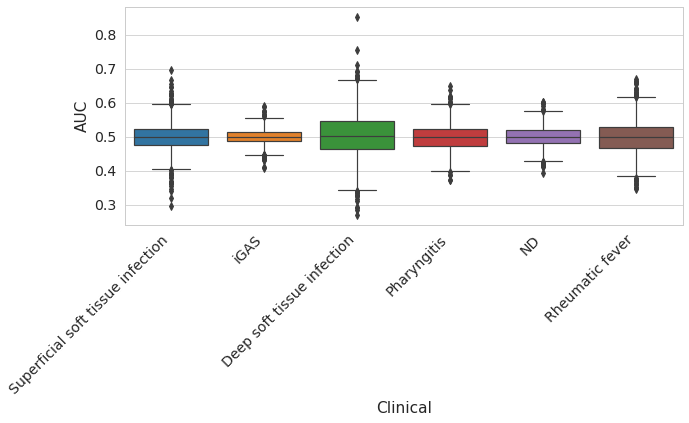

In [23]:
plt.figure(figsize=(10, 4))

# Taking those with N > 100

plot_df = auc_df_all[(auc_df_all['Positive [1]'] > 100) \
                     & (auc_df_all['Negative [0]'] > 100 )].copy()

ax = sns.boxplot(data=plot_df[['Clinical', 'AUC']], x='Clinical', y='AUC')
plt.xticks(rotation=45, ha='right');

In [24]:
max_aucs = pd.DataFrame(plot_df.groupby('Clinical')['AUC'].apply(max))
max_aucs

,AUC
Clinical,
Deep soft tissue infection,0.851432
ND,0.601463
Pharyngitis,0.649462
Rheumatic fever,0.669858
Superficial soft tissue infection,0.695076
iGAS,0.589872


In [27]:
min_aucs = pd.DataFrame(plot_df.groupby('Clinical')['AUC'].apply(min))
1- min_aucs

,AUC
Clinical,
Deep soft tissue infection,0.730008
ND,0.607425
Pharyngitis,0.628082
Rheumatic fever,0.654105
Superficial soft tissue infection,0.703484
iGAS,0.592244


In [28]:
aa = []

for i, v in enumerate(clinical):
    try:
        aa.append(plot_df[plot_df['AUC'] == max_aucs['AUC'][v]])
    except Exception:
        pass

pd.concat(aa)

,Clinical,AUC,Negative [0],Positive [1]
COG3649.faa.final_tree.fa,Superficial soft tissue infection,0.695076,406,137
COG4166.faa.final_tree.fa,iGAS,0.589872,1088,251
COG1674.faa.final_tree.fa,Deep soft tissue infection,0.851432,1038,185
COG1057.faa.final_tree.fa,Pharyngitis,0.649462,1179,158
COG0491.faa.final_tree.used_alg.fa,ND,0.601463,1234,105
COG1057.faa.final_tree.fa,Rheumatic fever,0.669858,1235,102


In [29]:
choosen_eggnogs = {}

temp_df = plot_df.copy()
temp_df['AUC'] = temp_df['AUC'].apply(lambda x: x if x > 0.5 else 1-x) 

choosen_clinical = temp_df.Clinical.value_counts().index

for i, v in enumerate(choosen_clinical):
    choosen_eggnogs[v] = temp_df[temp_df.Clinical == \
                                                v].sort_values('AUC', ascending=False)[:10].index
choosen_eggnogs

{'Superficial soft tissue infection': Index(['304Z7.faa.final_tree.fa', 'COG3649.faa.final_tree.fa',
        '33BC7.faa.final_tree.fa', '32R25.faa.final_tree.fa',
        'COG3646.faa.final_tree.fa', 'COG1312.faa.final_tree.fa',
        'COG1674.faa.final_tree.fa', '330BC.faa.final_tree.fa',
        '32UC6.faa.final_tree.fa', '33RTZ.faa.final_tree.fa'],
       dtype='object'),
 'iGAS': Index(['COG3649.faa.final_tree.fa', 'COG1680.faa.final_tree.fa',
        'COG4166.faa.final_tree.fa', '33BC7.faa.final_tree.fa',
        '32Q8G.faa.final_tree.fa', '30CZD.faa.final_tree.fa',
        '31UY3.faa.final_tree.fa', '2ZZTG.faa.final_tree.fa',
        'COG1206.faa.final_tree.fa', '33IDI.faa.final_tree.fa'],
       dtype='object'),
 'Deep soft tissue infection': Index(['COG1674.faa.final_tree.fa', 'COG1539.faa.final_tree.fa',
        'COG1057.faa.final_tree.fa', 'COG0415.faa.final_tree.fa',
        'COG1114.faa.final_tree.fa', '304XP.faa.final_tree.fa',
        'COG1316.faa.final_tree.fa', 'COG14

In [30]:
choosen_clinical

Index(['Superficial soft tissue infection', 'iGAS',
       'Deep soft tissue infection', 'Pharyngitis', 'ND', 'Rheumatic fever'],
      dtype='object')

In [34]:
def make_features(clinical):
    ## subset df with top models for given clinical
    sub_df = df2[df2.eggNOG.apply(lambda x: x in choosen_eggnogs[clinical].tolist())].copy()
    sub_df['Label'] = sub_df['Clinical'].apply(lambda x: 1 if x == clinical else 0)
    
    # GCAs
    gca = sub_df['GCA'].value_counts().index
    
    # eggNOG models for this clinical
    egg = choosen_eggnogs[clinical].tolist()
    
    # medians for NaNs
    med_df = pd.DataFrame(sub_df.groupby('eggNOG')['Bitscore'].median())
    
    # feature df
    feat_df = pd.DataFrame(columns=egg, index=gca)
    for i, v in enumerate(gca):
        for p, q in enumerate(egg):
            try:
                bitsc = sub_df[(sub_df.GCA == v) & (sub_df.eggNOG == q)]['Bitscore'].values[0]
            except Exception as exp:
#                 print(str(exp))
                bitsc = med_df.loc[q, 'Bitscore']
            feat_df.loc[v, q] = bitsc
        
    feat_df = feat_df.reset_index()
    feat_df = feat_df.rename(columns={'index':'GCA'})
    feat_df = pd.merge(feat_df, sub_df[['GCA', 'Label']], on='GCA')
    return med_df, feat_df


In [35]:
from sklearn.ensemble import RandomForestClassifier



med_dfs = {}
feat_dfs = {}
choosen_models = {}
classifiers = {}

for i, v in enumerate(choosen_clinical):
    med, feat = make_features(v)
    med_dfs[v] = med
    feat_dfs[v] = feat
    choosen_models[v] = choosen_eggnogs[v]

    X, y = feat[choosen_eggnogs[v]], feat.Label
    clf = RandomForestClassifier(random_state=12345)
    clf.fit(X, y)

    classifiers[v] = clf
    progress(i, len(choosen_clinical))


In [41]:
results = [med_dfs, feat_dfs, choosen_models, classifiers]
results_name = ['Medians', 'Features', 'Choosen_Models', 'Classifiers']

import pickle

for i, v in enumerate(results):
    with open('results/{}.pkl'.format(results_name[i]), 'wb') as handle:
        pickle.dump(v, handle)